In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit,linprog
from src.new_model import HEV

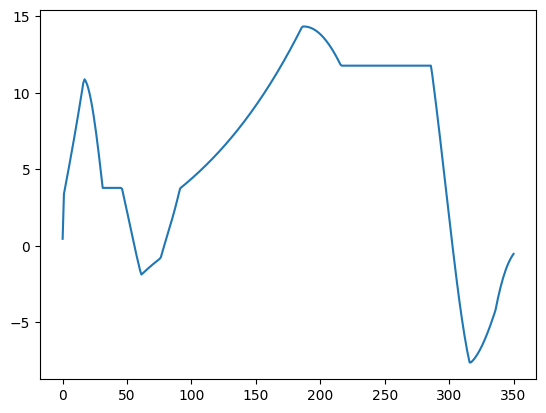

In [38]:
alpha = np.load('data/fake-slope.npy')
alpha = np.zeros_like(alpha)
v = np.load('data/fake-velocity.npy') # VELOCITY GETS ALTERED BY FN
a = np.load('data/fake-acceleration.npy')
ts = np.load('data/fake-time.npy')
c = HEV()
F_t = c.force_balance(a=a,v=v,alpha=alpha)
Ps = c.generate_power_req(v=v,F_t=F_t)
Ps = Ps/1000 # W to kW
# Ps[Ps<0]=0
ice_eff, em_eff = c.generate_eff_curves(v=v,F_t=F_t,t=ts)
plt.plot(ts,Ps)

In [39]:
# set parameters
# Power outputs
EV_discharge_lim = 80 #kW
EV_charge_lim = 60 #kW
IC_power_lim = 200 #kW

# Starting charge
charge_max = 1000
charge_0 = 500

# costs
fuel_cost = 1
battery_cost = 0

# Set up linear optimisation
intervals = np.size(Ps,0)

# Cost function
f = np.concatenate((battery_cost*np.ones(intervals),battery_cost*np.ones(intervals),ice_eff*np.ones(intervals)))

# Inequality conditions
A = np.concatenate(
    (np.concatenate((np.tril(np.ones([intervals,intervals])),-1*np.tril(np.ones([intervals,intervals])),np.zeros([intervals,intervals])),1),
     np.concatenate((-1*np.tril(np.ones([intervals,intervals])),np.tril(np.ones([intervals,intervals])),np.zeros([intervals,intervals])),1),
     np.concatenate((-1*np.eye(intervals),np.eye(intervals),np.eye(intervals)),1))
     ,0)
b = np.concatenate((charge_0*np.ones(intervals),(charge_max-charge_0)*np.ones(intervals),-Ps),0)

# Equality conditions
Aeq = None # Shouldn't the charge and discharge be an equality constraint?
beq = None

# Upper bounds
ub = np.concatenate((np.ones(intervals) * EV_discharge_lim
                     ,np.ones(intervals) * EV_charge_lim
                     ,np.ones(intervals) * IC_power_lim)
                    ,0)

# Lower bounds
lb = np.concatenate((np.ones(intervals) # EM discharge > 0
                     ,np.zeros(intervals) # EM charge > 0
                     ,np.zeros(intervals)) # ICE power > 0
                    ,0)

res = linprog(f, A_ub=A, b_ub=b, A_eq=Aeq, b_eq=beq, bounds=(np.transpose([lb, ub])))
res

       message: The problem is infeasible. (HiGHS Status 8: model_status is Infeasible; primal_status is At lower/fixed bound)
       success: False
        status: 2
           fun: None
             x: None
           nit: 0
         lower:  residual: None
                marginals: None
         upper:  residual: None
                marginals: None
         eqlin:  residual: None
                marginals: None
       ineqlin:  residual: None
                marginals: None

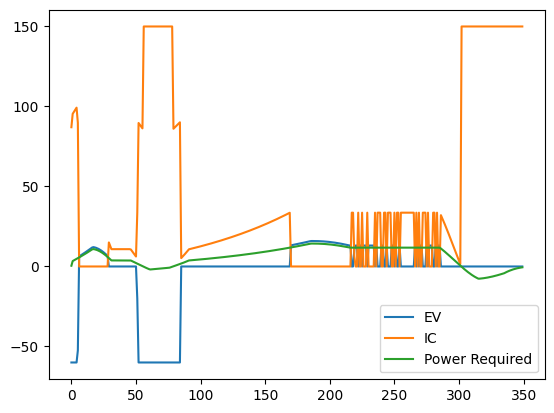

In [28]:
results = np.reshape(res.x,(3,-1)).T
EV = results[:,0] - results[:,1]
IC = results[:,2]

plt.plot(range(intervals),np.stack((EV,IC),1))
plt.plot(range(intervals),Ps)

plt.legend(['EV','IC','Power Required'])

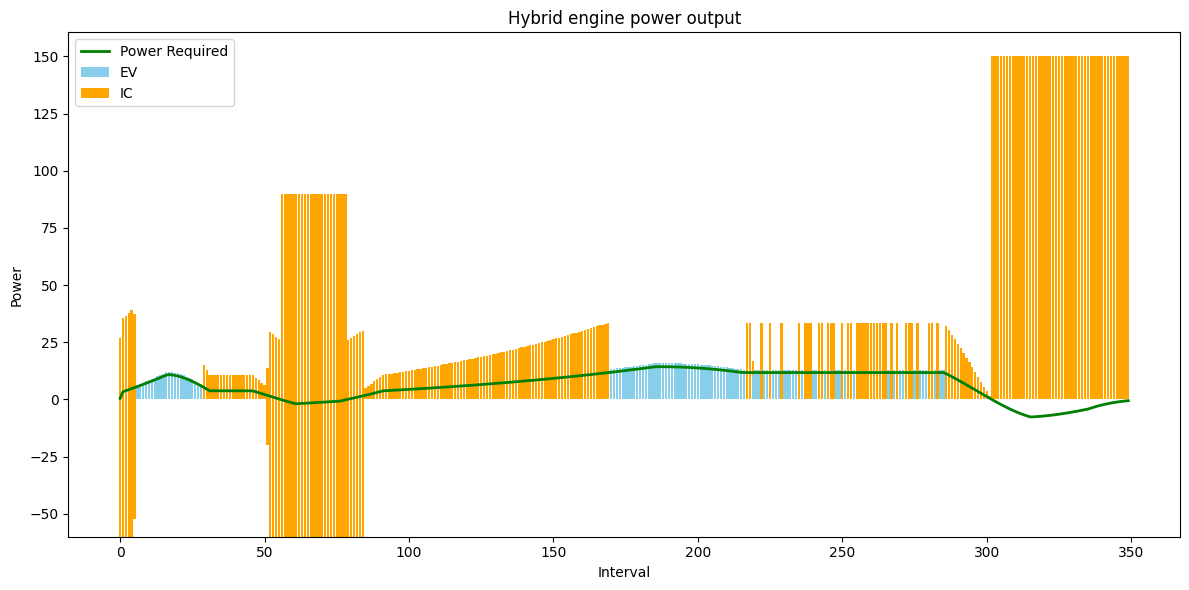

In [29]:
# Create the stacked bar plot
fig, ax = plt.subplots(figsize=(12, 6))

x = range(intervals)
width = 0.8

ax.bar(x, EV, width, label='EV', color='skyblue')
ax.bar(x, IC, width, bottom=EV, label='IC', color='orange')

# Plot the Power Required line
ax.plot(x, Ps, color='green', linewidth=2, label='Power Required')

ax.set_xlabel('Interval')
ax.set_ylabel('Power')
ax.set_title('Hybrid engine power output')
ax.legend()

plt.tight_layout()
plt.show()